## DNABERT2-compatible visualization and motif region extraction


In [ ]:
# dnabert_aug_2025_jupyter

In [27]:
import torch
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification, AutoModel
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import ast
import ahocorasick
import os
import difflib
from itertools import combinations
import glob

from scipy.stats import hypergeom
from statsmodels.stats.multitest import multipletests
from Bio import pairwise2
from Bio import motifs
from Bio import SeqIO


In [28]:
# === Config ===
base_path = "/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/dnabert2_FineTune_Zhihan_attention_extracted/july_2025_mmseq"
base_model_nms = ["TSp_vs_nonProm", "TSp_vs_genNullseqs"]
length_nm = "3k"
subsets = ["tspAll_", "tspliver_", "tsptestis_", "tspbrain_"]

data_path = "/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/dnabert2_FineTune_Zhihan_attention_extracted/data/jul_2025/split"
tokenizer_name = 'jaandoui/DNABERT2-AttentionExtracted'

In [29]:
jobs = []

for base_model_nm in base_model_nms:
    length_dir = os.path.join(base_path, base_model_nm, length_nm)
    if not os.path.exists(length_dir):
        print(f"⚠️ Missing length dir: {length_dir}")
        continue

    # All dirs under length_dir
    all_subdirs = [d for d in os.listdir(length_dir) if os.path.isdir(os.path.join(length_dir, d))]

    # Match subset dirs by prefix
    matched_subdirs = [d for d in all_subdirs if any(d.startswith(pref) for pref in subsets)]
    if not matched_subdirs:
        print(f"⚠️ No matching subset dirs under {length_dir}")
        continue

    for subset in matched_subdirs:
        search_dir = os.path.join(length_dir, subset)

        # lr dirs: accept anything starting with "lr3e-5"
        lr_dirs = [d for d in os.listdir(search_dir) if d.startswith("lr3e-5")]
        if not lr_dirs:
            print(f"⚠️ No lr3e-5 dirs under {search_dir}")
            continue

        for lr_dir in lr_dirs:
            model_dir = os.path.join(search_dir, lr_dir)
            checkpoints = [d for d in os.listdir(model_dir) if d.startswith("checkpoint-")]
            if not checkpoints:
                print(f"⚠️ No checkpoints in {model_dir}")
                continue

            # Pick latest checkpoint
            latest_ckpt = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))[-1]
            model_path = os.path.join(model_dir, latest_ckpt)

            # Data dir mirrors actual subset name
            data_dir = os.path.join(data_path, base_model_nm, length_nm, subset)

            # Result dir mirrors lr-dir
            res_pdir = f"{base_path}/RESULT/{lr_dir}/{base_model_nm}_{length_nm}_{subset}"
            os.makedirs(res_pdir, exist_ok=True)

            jobs.append({
                "base_model_nm": base_model_nm,
                "subset": subset,
                "lr_dir": lr_dir,
                "model_path": model_path,
                "data_dir": data_dir,
                "res_pdir": res_pdir,
            })

print(f"-> Collected {len(jobs)} jobs")
for j in jobs:
    print(f"** {j['base_model_nm']} | {j['subset']} | {j['lr_dir']} | {os.path.basename(j['model_path'])}")


-> Collected 8 jobs
** TSp_vs_nonProm | tspbrain_nonPromHu | lr3e-5_ep10 | checkpoint-600
** TSp_vs_nonProm | tsptestis_nonPromHu | lr3e-5_ep10 | checkpoint-4100
** TSp_vs_nonProm | tspAll_nonPromHu | lr3e-5_ep10 | checkpoint-6400
** TSp_vs_nonProm | tspliver_nonPromHu | lr3e-5_ep10 | checkpoint-200
** TSp_vs_genNullseqs | tspAll_genNullseqs | lr3e-5_ep10 | checkpoint-7300
** TSp_vs_genNullseqs | tspliver_genNullseqs | lr3e-5_ep10 | checkpoint-300
** TSp_vs_genNullseqs | tsptestis_genNullseqs | lr3e-5_ep10 | checkpoint-5400
** TSp_vs_genNullseqs | tspbrain_genNullseqs | lr3e-5_ep10 | checkpoint-300


In [30]:
# run it for one job ahead to check
job_to_run = jobs[7]
job_to_run

{'base_model_nm': 'TSp_vs_genNullseqs',
 'subset': 'tspbrain_genNullseqs',
 'lr_dir': 'lr3e-5_ep10',
 'model_path': '/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/dnabert2_FineTune_Zhihan_attention_extracted/july_2025_mmseq/TSp_vs_genNullseqs/3k/tspbrain_genNullseqs/lr3e-5_ep10/checkpoint-300',
 'data_dir': '/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/dnabert2_FineTune_Zhihan_attention_extracted/data/jul_2025/split/TSp_vs_genNullseqs/3k/tspbrain_genNullseqs',
 'res_pdir': '/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/dnabert2_FineTune_Zhihan_attention_extracted/july_2025_mmseq/RESULT/lr3e-5_ep10/TSp_vs_genNullseqs_3k_tspbrain_genNullseqs'}

In [38]:
data_dir

'/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/dnabert2_FineTune_Zhihan_attention_extracted/data/jul_2025/split/TSp_vs_genNullseqs/3k/tspbrain_genNullseqs'

In [23]:
all_layer_records = []

# === Load model and tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, trust_remote_code=True)
model = AutoModelForSequenceClassification.from_pretrained(job_to_run['model_path'], output_attentions=True, trust_remote_code=True)
model.eval()

for split_file in ['train.csv', 'dev.csv', 'test.csv']:
    split = split_file.replace('.csv','')
    path = f"{data_dir}/{split_file}"
    df_raw = pd.read_csv(path)
    sequences = df_raw['Sequence'].tolist()
    labels = df_raw['Label'].tolist()

    inputs = tokenizer(sequences, padding=True, truncation=True, max_length=256, return_tensors='pt')
    
    with torch.no_grad():
        outputs = model(**inputs)

    all_attentions = torch.stack(outputs.attentions, dim=0)  # (layers, batch, heads, seq, seq)
    num_layers = all_attentions.shape[0]

    for layer_idx in range(num_layers):
        layer_attn = all_attentions[layer_idx]  # (batch, heads, seq, seq)
        avg_attn = layer_attn.mean(dim=1)       # (batch, seq, seq)

        for i, seq in enumerate(sequences):
            token_ids = inputs['input_ids'][i]
            tokens = tokenizer.convert_ids_to_tokens(token_ids)
            attn_score = avg_attn[i].sum(dim=0)   # (seq_len,)
            attn_score = attn_score / attn_score.max()  # normalize
            attn_score_list = attn_score.cpu().numpy().tolist()

            all_layer_records.append({
                'split': split,
                'layer': layer_idx,
                'label': labels[i],
                'sequence': seq,
                'tokens': tokens,
                'attn_scores': attn_score_list,
            })

# Convert to DataFrame
raw_df = pd.DataFrame(all_layer_records)
raw_df.to_parquet(f"{job_to_run['res_pdir']}/1_Attention_raw.parquet", index=False)


/home/campus.stonybrook.edu/psurana/anaconda3/envs/dnabert_aug_2025_jupyter/lib/python3.8/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/campus.stonybrook.edu/psurana/.cache/huggingface/modules/transformers_modules/jaandoui/DNABERT2-AttentionExtracted/cb70b22cf09b210483473386a2d3db72dfd893f1/bert_layers.py:128: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(


In [24]:
print(raw_df.shape)
raw_df.head(3)


(12816, 6)


,split,layer,label,sequence,tokens,attn_scores
0,train,0,1,CGAGTGCACAATAGAGCCGGCCGCGAGCAGGCTGTTCCCCGGCAGG...,"[[CLS], CGA, GTG, CACAA, TAGA, GCC, GGCC, GC, ...","[1.0, 0.03787402808666229, 0.03882480412721634..."
1,train,0,1,AGTGAGATGTTCCCATGTAGCACATGTGGATGAGTTCACACTCAGA...,"[[CLS], A, GTGA, GATGTT, CCCATG, TAGCA, CATGTG...","[1.0, 0.05571534112095833, 0.04114381596446037..."
2,train,0,0,TAAATGGGTGAACATATAAAGAGGAGCACATATGTAAGTCAAATGA...,"[[CLS], TAAA, TGGG, TGAA, CATA, TAAA, GAGGA, G...","[1.0, 0.03568153828382492, 0.04271512478590011..."


In [31]:
raw_df['split'].value_counts()

split
train    10248
dev       1284
test      1284
Name: count, dtype: int64

In [32]:
# filter only last layer fro now
# we are interested in the regions the model focuses on
# motif_raw_df = raw_df[raw_df['layer'] == 11]
motif_raw_df = raw_df

motif_raw_df.shape

(12816, 6)

In [33]:
def process_row(row):
    try:
        tokens = ast.literal_eval(str(row['tokens']))
        scores = ast.literal_eval(str(row['attn_scores']))
    except (ValueError, SyntaxError):
        return pd.DataFrame()  # Skip malformed rows
    
    if len(tokens) != len(scores):
        return pd.DataFrame()
    
    # Repeat metadata for each token
    expanded = pd.DataFrame({
        'split': [row['split']] * len(tokens),
        'layer': [row['layer']] * len(tokens),
        'label': [row['label']] * len(tokens),
        'sequence': [row['sequence']] * len(tokens),
        'token': tokens,
        'attn_score': scores
    })
    
    return expanded

# Expand all rows
motif_raw_df1 = pd.concat(
    [process_row(row) for _, row in motif_raw_df.iterrows()],
    ignore_index=True
)

# Remove rows where the token starts with '['
motif_raw_df1 = motif_raw_df1[~motif_raw_df1['token'].astype(str).str.startswith('[')].reset_index(drop=True)
motif_raw_df1.head(3)

,split,layer,label,sequence,token,attn_score
0,train,0,1,CGAGTGCACAATAGAGCCGGCCGCGAGCAGGCTGTTCCCCGGCAGG...,CGA,0.037874
1,train,0,1,CGAGTGCACAATAGAGCCGGCCGCGAGCAGGCTGTTCCCCGGCAGG...,GTG,0.038825
2,train,0,1,CGAGTGCACAATAGAGCCGGCCGCGAGCAGGCTGTTCCCCGGCAGG...,CACAA,0.045198


In [34]:
# Apply base-pair start/end computation to each row
def compute_token_bounds(row):
    sequence = row['sequence']
    token = row['token']
    start = sequence.find(token)
    end = start + len(token) if start != -1 else None
    return pd.Series({'start_pos': start + 1, 'end_pos': end + 1})

# Apply the function row-wise
motif_raw_df1[['start_pos', 'end_pos']] = motif_raw_df1.apply(compute_token_bounds, axis=1)

motif_raw_df1['token_length'] = motif_raw_df1['end_pos'].astype(int) - motif_raw_df1['start_pos'].astype(int)


In [35]:
# Group by sequence and apply cutoff logic within each group
def apply_attention_mask(group):
    scores = group['attn_score']
    token_len = group['token_length']
    mean_attn = scores.mean()
    min_attn = scores.min()

    length_filter = token_len >= 4
    mask = (scores > mean_attn) & (scores > 2 * min_attn) & length_filter

    group = group.copy()
    group['mask'] = mask.astype(int)
    return group


In [36]:
# Apply per-sequence
motif_raw_df2 = motif_raw_df1.groupby('sequence', group_keys=False).apply(apply_attention_mask)
print(motif_raw_df2['mask'].value_counts())

mask
0    2341229
1     914035
Name: count, dtype: int64


In [37]:
motif_raw_df2['sequence'].drop_duplicates()

0          CGAGTGCACAATAGAGCCGGCCGCGAGCAGGCTGTTCCCCGGCAGG...
254        AGTGAGATGTTCCCATGTAGCACATGTGGATGAGTTCACACTCAGA...
508        TAAATGGGTGAACATATAAAGAGGAGCACATATGTAAGTCAAATGA...
762        ACTCTTGTCACCATTTTGGTTTTGGTGGTTTATAGCAGGCTCCTTT...
1016       ATTCCAGGATGGCCAGGTGGACCCGGGGCCAGTGCTCCCAGCCTTC...
                                 ...                        
2955036    GTTAGAGTGTTCCATCACCCTAAATGCTGGGAAACCAAGCGAATCT...
2955290    ACCCTCTTTGGGTCTCAAAAATTCCTAATAATTGCGTGCAATTCCC...
2955544    AGAACTTTTATGAATCACCTATTACTATTCAGCAGTTCAGAAAAGC...
2955798    GTCTATTGGGCAGACATTGTTAAAAGTAAATAAATTCTTAAAATTA...
2956052    AAAGCTGGGGGTAGGGAAAGGAGACAAGTGCTCATACTTACCTCCC...
Name: sequence, Length: 1068, dtype: object

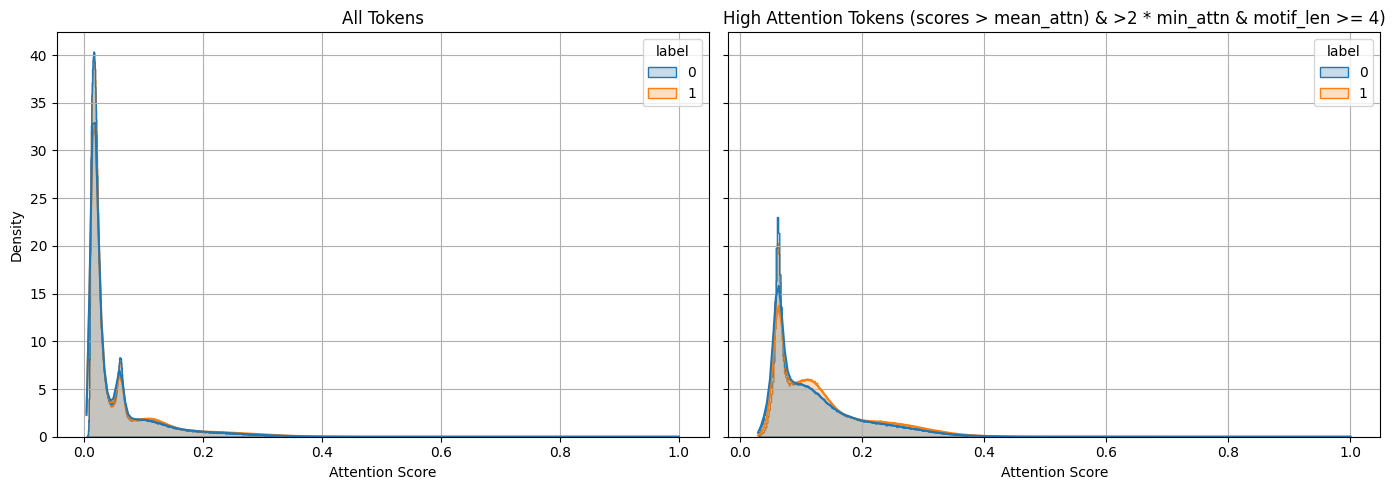

In [18]:
# Filtered for mask == 1
filtered_df = motif_raw_df2[motif_raw_df2['mask'] == 1]

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Plot 1: full data
sns.histplot(data=motif_raw_df2, x='attn_score', hue='label', kde=True, element='step', stat='density', common_norm=False, ax=axes[0])
axes[0].set_title('All Tokens')
axes[0].set_xlabel('Attention Score')
axes[0].set_ylabel('Density')
axes[0].grid(True)

# Plot 2: filtered (mask == 1)
sns.histplot(data=filtered_df, x='attn_score', hue='label', kde=True, element='step', stat='density', common_norm=False, ax=axes[1])
axes[1].set_title('High Attention Tokens (scores > mean_attn) & >2 * min_attn & motif_len >= 4)')
axes[1].set_xlabel('Attention Score')
axes[1].set_ylabel('Density')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [235]:
filtered_df['split'].value_counts()

split
test    8722
dev     8637
Name: count, dtype: int64

In [238]:
filtered_df.shape

(17359, 10)

In [ ]:
# === Step 1: Extract motif instances ===
# Only from mask==1
motif_df = filtered_df[filtered_df['mask'] == 1].copy()

# === Step 2: Get list of unique motifs ===
motifs = motif_df['token'].unique().tolist()

# === Step 3: Group sequences by label ===
# Make sure sequences are unique per group
pos_seqs = motif_df[motif_df['label'] == 1]['sequence'].unique().tolist()
neg_seqs = motif_df[motif_df['label'] == 0]['sequence'].unique().tolist()

print(len(pos_seqs), len(neg_seqs))

In [243]:
# # === Step 4: Count motif hits in sequences using Aho-Corasick ===
# def count_motif_hits(seqs, motifs):
#     motif_count = {motif: 0 for motif in motifs}
#     A = ahocorasick.Automaton()
#     for idx, motif in enumerate(motifs):
#         A.add_word(motif, (idx, motif))
#     A.make_automaton()

#     for seq in seqs:
#         found = set()
#         for _, (_, motif) in A.iter(seq):
#             found.add(motif)
#         for motif in found:
#             motif_count[motif] += 1
#     return motif_count

# # === Step 5: Compute stats ===
# N = len(pos_seqs) + len(neg_seqs)
# K = len(pos_seqs)

# pos_hits = count_motif_hits(pos_seqs, motifs)
# neg_hits = count_motif_hits(neg_seqs, motifs)
# all_hits = {motif: pos_hits[motif] + neg_hits[motif] for motif in motifs}

# records = []
# for motif in motifs:
#     n = all_hits[motif]          # total sequences with motif
#     k = pos_hits[motif]          # positive sequences
#     neg = neg_hits[motif]        # negative sequences
#     pval = hypergeom.sf(k - 1, N, n, K)

#     # Classify hit type
#     if k > 0 and neg == 0:
#         hit_type = "positive_only"
#     elif neg > 0 and k == 0:
#         hit_type = "negative_only"
#     elif k > 0 and neg > 0:
#         hit_type = "both"
#     else:
#         hit_type = "none"

#     records.append((motif, n, k, neg, pval, hit_type))

# motif_list, n_list, k_list, neg_list, pval_list, hit_type_list = zip(*records)
# _, adj_pvals, _, _ = multipletests(pval_list, alpha=0.005, method='fdr_bh')

# result_df = pd.DataFrame({
#     'motif': motif_list,
#     'n_total': n_list,
#     'pos_hits': k_list,
#     'neg_hits': neg_list,
#     'pval': pval_list,
#     'adj_pval': adj_pvals,
#     'hit_type': hit_type_list
# })


In [244]:
significant_df = result_df[result_df['adj_pval'] < 0.005].sort_values('adj_pval')
significant_df.head(10)

,motif,n_total,pos_hits,neg_hits,pval,adj_pval,hit_type
1,GCGC,487,341,146,2.530713e-52,2.178944e-49,both
20,GCGG,517,347,170,6.561698e-46,2.824811e-43,both
510,CCGC,530,351,179,1.953507e-44,5.606565e-42,both
120,CGCC,560,356,204,2.652596e-38,5.709712e-36,both
124,GGCGC,252,197,55,4.039847e-35,6.956616e-33,both
531,GCGCC,263,199,64,9.105454e-32,1.306633e-29,both
418,CCGCC,314,223,91,4.090671e-29,5.031526e-27,both
404,CCCGC,300,214,86,4.594392e-28,4.944714e-26,both
99,CGCA,387,257,130,5.804219e-27,5.552703e-25,both
3,CGGA,436,280,156,2.074636e-26,1.786262e-24,both


In [245]:

# === Step 1: Extract motif instances (mask == 1)
motif_df = filtered_df[filtered_df['mask'] == 1].copy()

# === Step 2: Unique motifs
motifs = motif_df['token'].unique().tolist()

# === Step 3: Unique sequences by label
pos_seqs = motif_df[motif_df['label'] == 1]['sequence'].unique().tolist()
neg_seqs = motif_df[motif_df['label'] == 0]['sequence'].unique().tolist()

# === Step 4: Motif hit counter (Aho-Corasick)
def count_motif_hits(seqs, motifs):
    motif_count = {motif: 0 for motif in motifs}
    A = ahocorasick.Automaton()
    for idx, motif in enumerate(motifs):
        A.add_word(motif, (idx, motif))
    A.make_automaton()
    
    for seq in seqs:
        found = set()
        for _, (_, motif) in A.iter(seq):
            found.add(motif)
        for motif in found:
            motif_count[motif] += 1
    return motif_count

# === Step 5: Compute stats
N = len(pos_seqs) + len(neg_seqs)
K = len(pos_seqs)

pos_hits = count_motif_hits(pos_seqs, motifs)
neg_hits = count_motif_hits(neg_seqs, motifs)

# Prepare lists for FDR correction
pvals = []
motif_keys = []
n_total_dict = {}
pos_dict = {}
neg_dict = {}
hit_type_dict = {}

for motif in motifs:
    k = pos_hits[motif]
    neg = neg_hits[motif]
    n = k + neg
    pval = hypergeom.sf(k - 1, N, n, K)

    if k > 0 and neg == 0:
        hit_type = "positive_only"
    elif neg > 0 and k == 0:
        hit_type = "negative_only"
    elif k > 0 and neg > 0:
        hit_type = "both"
    else:
        hit_type = "none"

    pvals.append(pval)
    motif_keys.append(motif)
    n_total_dict[motif] = n
    pos_dict[motif] = k
    neg_dict[motif] = neg
    hit_type_dict[motif] = hit_type

# === Step 6: FDR correction
adj_pvals = multipletests(pvals, alpha=0.005, method='fdr_bh')[1]
adj_pval_dict = dict(zip(motif_keys, adj_pvals))

# === Step 7: Add to motif_df directly
motif_df['n_total'] = motif_df['token'].map(n_total_dict)
motif_df['pos_hits'] = motif_df['token'].map(pos_dict)
motif_df['neg_hits'] = motif_df['token'].map(neg_dict)
motif_df['pval'] = motif_df['token'].map(dict(zip(motif_keys, pvals)))
motif_df['adj_pval'] = motif_df['token'].map(adj_pval_dict)
motif_df['hit_type'] = motif_df['token'].map(hit_type_dict)


In [246]:
significant_df = motif_df[motif_df['adj_pval'] < 0.005].sort_values('adj_pval')
significant_df.tail(10)

,split,layer,label,sequence,token,attn_score,start_pos,end_pos,token_length,mask,n_total,pos_hits,neg_hits,pval,adj_pval,hit_type
179593,dev,11,0,CGTTAGACCCACGGGACTTGGCACCCTGGAACGCTCACCATCCCCG...,GCTA,0.180536,196,200,4,1,2057,1160,897,0.000749,0.004752,both
372651,test,11,0,CCATGTGCATTGCAGGCATTTATTTAATACTTGGATCAAAGAATGT...,GCTA,0.356551,128,132,4,1,2057,1160,897,0.000749,0.004752,both
163551,dev,11,1,CAGCCCAAGCCGCAGTTGCCAGCGGGTGCTTGACTAGACACGCGGC...,GCTA,0.338710,193,197,4,1,2057,1160,897,0.000749,0.004752,both
130842,dev,11,1,GCAAACAGAGCTTCACCCTAGAAATTGGGGAAAATGAGGAACAGGT...,CAACAA,0.202309,179,185,6,1,256,162,94,0.000759,0.004804,both
304742,test,11,1,GATAGGGAGTGCCTAACTACAACATTATCATTTTCTTCTCTTTCCA...,TAACTA,0.245716,14,20,6,1,119,81,38,0.000761,0.004804,both
295166,test,11,0,CCACAGGTAAGGCGGGCGCCGCTGCCCCTCAAATGGCGTCGGGGAC...,CAACAA,0.171636,176,182,6,1,256,162,94,0.000759,0.004804,both
245956,test,11,0,GATTGTGCAGTCATAGTCAACGTTCATTGAGAGCTTACTTTATATA...,TGACAA,0.236801,195,201,6,1,263,166,97,0.000782,0.004916,both
238214,test,11,1,CCACTCCTGCTGCCTCCAGGATGTCCCCTGTTTCCCCAGCCCCTCT...,TGACAA,0.311395,195,201,6,1,263,166,97,0.000782,0.004916,both
122661,dev,11,1,CCATTTTGCCCAGGCTGGTCTCGAACTCCTGGGCTCAAGCGATCCA...,GTACAGA,0.472647,194,201,7,1,53,40,13,0.000782,0.004916,both
157938,dev,11,1,GTTTTACCATGTTGCCCAGGCTGTTCTTCACCTCCTGGCCTCAAGT...,TGACAA,0.287233,190,196,6,1,263,166,97,0.000782,0.004916,both


In [247]:
significant_df['label'].value_counts()

label
1    3278
0    1886
Name: count, dtype: int64

In [249]:
res_pdir

'/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/methyl_luad/model/TSS_200bp_beta/RES/lr2e-5_bs40_ep10'

In [251]:
significant_df.to_csv(res_pdir + '/sig_motifs.csv')

In [252]:
significant_df['sequence'].nunique()

3483

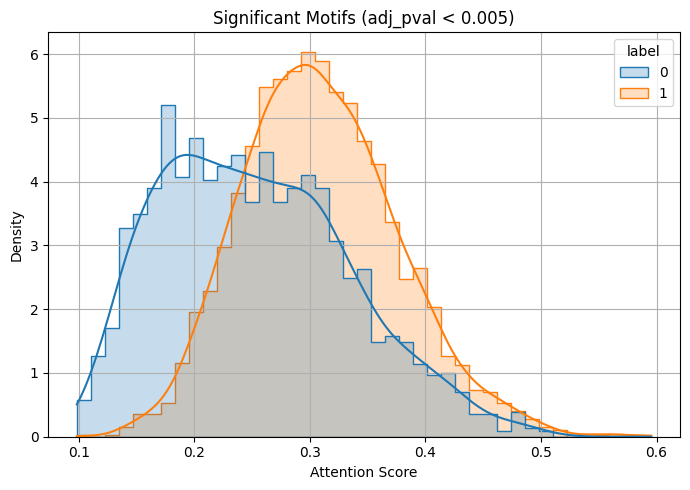

In [254]:
# Create a single plot
plt.figure(figsize=(7, 5))

# Plot: significant motifs (adj_pval < 0.005)
sns.histplot(
    data=significant_df[significant_df['adj_pval'] < 0.005],
    x='attn_score',
    hue='label',
    kde=True,
    element='step',
    stat='density',
    common_norm=False
)

plt.title('Significant Motifs (adj_pval < 0.005)')
plt.xlabel('Attention Score')
plt.ylabel('Density')
plt.grid(True)
plt.tight_layout()
plt.show()


In [255]:
# Step 1: Group by unique motif (token) and store sequences
motif_instances = significant_df.groupby("token")["sequence"].apply(list).to_dict()
tokens = list(motif_instances.keys())

# Step 2: Perform pairwise alignment between all motif tokens
def simple_gapless_score(a, b):
    """Return number of matching characters in best gap-free alignment"""
    scores = []
    len_a, len_b = len(a), len(b)
    for i in range(-len_b + 1, len_a):
        score = 0
        for j in range(max(0, i), min(len_a, i + len_b)):
            if a[j] == b[j - i]:
                score += 1
        scores.append(score)
    return max(scores)

# Step 3: Merge motifs based on alignment
merge_map = {}
visited = set()

for a, b in combinations(tokens, 2):
    if a in visited or b in visited:
        continue
    score = simple_gapless_score(a, b)
    min_len = min(len(a), len(b))
    req_len = max(min_len - 1, min_len // 2)
    if score >= req_len:
        merge_map[b] = a
        visited.add(b)

# Step 4: Assign merged motifs
significant_df['merged_token'] = significant_df['token'].apply(lambda x: merge_map.get(x, x))


In [256]:
def extract_centered_window(row, flank=12):
    seq = row['sequence']
    mid = (row['start_pos'] + row['end_pos']) // 2
    start = max(0, mid - flank)
    end = mid + flank
    window_seq = seq[start:end]
    return window_seq if len(window_seq) == 2 * flank else None

# Apply to each motif instance (based on original token location)
significant_df['window_seq'] = significant_df.apply(extract_centered_window, axis=1)

# Remove rows that couldn't be extracted properly
significant_df = significant_df.dropna(subset=['window_seq']).reset_index(drop=True)


In [257]:
significant_df['sequence'][0]

'GGCTTGCCCACCCAGGGAGGTTCACCAGCACCCAAGCACACAGCACAGGGCCAGCAGCACAGCCCCGGGCCCTCAGCGGGCACCTGACCCCTCACCCTCCGGCTCCCCGCGCTGTAGCATGAGAACCGCCTCCTGTCCCACCTCAGGGCCTTTGCAACTGCTGCCTCTACAACCAGAAATTTCCCCTGGCATCTTCATGG'

In [258]:
significant_df.head(12)

,split,layer,label,sequence,token,attn_score,start_pos,end_pos,token_length,mask,n_total,pos_hits,neg_hits,pval,adj_pval,hit_type,merged_token,window_seq
0,dev,11,1,GGCTTGCCCACCCAGGGAGGTTCACCAGCACCCAAGCACACAGCAC...,CATG,0.354938,118,122,4,1,3207,2120,1087,1.393166e-87,3.764334e-84,both,CAAGCA,GCGCTGTAGCATGAGAACCGCCTC
1,dev,11,1,GAGTGACCCAGTAAATTTCAGGTTCTGGCTCAGCCATGGCTCGACA...,CATG,0.343021,35,39,4,1,3207,2120,1087,1.393166e-87,3.764334e-84,both,CAAGCA,TGGCTCAGCCATGGCTCGACAGTC
2,dev,11,1,ATTGATCTCTGTTCTCCGGTGACTTTAGGGAAAGACTGTACCTCAT...,CATG,0.479972,185,189,4,1,3207,2120,1087,1.393166e-87,3.764334e-84,both,CAAGCA,GGAGGGGTGCATGGAGGCGCCTGC
3,test,11,1,GGAGACACGTCCAGGCTGTGGAGGGAGACAAAACCGTGAGCCTCCT...,CATG,0.246998,174,178,4,1,3207,2120,1087,1.393166e-87,3.764334e-84,both,CAAGCA,AGACCCCAACATGTAACATTATCA
4,test,11,1,GAAAAAATAGGCAAAAATAAACATATTTAATTTATACACATATACA...,CATG,0.292475,45,49,4,1,3207,2120,1087,1.393166e-87,3.764334e-84,both,CAAGCA,ACACATATACATGTGTATAGTTTT
5,dev,11,1,ACAGCAAAAGAGGTAATACATCAATTCAGTCTTAACAAATGCCACA...,CATG,0.327999,56,60,4,1,3207,2120,1087,1.393166e-87,3.764334e-84,both,CAAGCA,GAAAGCTAGCATGTTCCATAGAGT
6,test,11,0,CTGCTGGCAGGAGAAGAGGACCCAGCTCAGCAGTGACCACAGATCT...,CATG,0.431212,156,160,4,1,3207,2120,1087,1.393166e-87,3.764334e-84,both,CAAGCA,CAACAGCTGCATGAGTCAGCAAGC
7,dev,11,1,TGATGGCAGGATTAATGTGTATGAAGGCACACGGACGTCAGAACCT...,CATG,0.322511,64,68,4,1,3207,2120,1087,1.393166e-87,3.764334e-84,both,CAAGCA,GAAACTAGGCATGCTGACTGCTTT
8,dev,11,1,TGGTTTGTGCCGCAGGTTTGGGCGCAGGCTGGTGCTAACCTGGAGC...,CATG,0.325410,148,152,4,1,3207,2120,1087,1.393166e-87,3.764334e-84,both,CAAGCA,GGCAGGCGTCATGATGAACACGGG
9,test,11,1,TTTCCCACAAGATCATGGCTCAAAAACCAACAAAAGTCTCCTTCCT...,CATG,0.196764,14,18,4,1,3207,2120,1087,1.393166e-87,3.764334e-84,both,CAAGCA,CCACAAGATCATGGCTCAAAAACC


In [259]:
# Count number of instances per merged motif
motif_counts = significant_df['merged_token'].value_counts()

# Keep only motifs with ≥ 3 instances
valid_motifs = motif_counts[motif_counts >= 3].index

significant_df1 = significant_df[significant_df['merged_token'].isin(valid_motifs)].reset_index(drop=True)

In [260]:
significant_df1['label'].value_counts()

label
1    1821
0     990
Name: count, dtype: int64

In [261]:
significant_df1.to_csv(res_pdir + '/2sig_motifs_prePWM.csv')

In [262]:
significant_df1.head(3)

,split,layer,label,sequence,token,attn_score,start_pos,end_pos,token_length,mask,n_total,pos_hits,neg_hits,pval,adj_pval,hit_type,merged_token,window_seq
0,dev,11,1,GGCTTGCCCACCCAGGGAGGTTCACCAGCACCCAAGCACACAGCAC...,CATG,0.354938,118,122,4,1,3207,2120,1087,1.393166e-87,3.764334e-84,both,CAAGCA,GCGCTGTAGCATGAGAACCGCCTC
1,dev,11,1,GAGTGACCCAGTAAATTTCAGGTTCTGGCTCAGCCATGGCTCGACA...,CATG,0.343021,35,39,4,1,3207,2120,1087,1.393166e-87,3.764334e-84,both,CAAGCA,TGGCTCAGCCATGGCTCGACAGTC
2,dev,11,1,ATTGATCTCTGTTCTCCGGTGACTTTAGGGAAAGACTGTACCTCAT...,CATG,0.479972,185,189,4,1,3207,2120,1087,1.393166e-87,3.764334e-84,both,CAAGCA,GGAGGGGTGCATGGAGGCGCCTGC


In [263]:
# Your DataFrame
df = significant_df1

# Set output directory
output_dir = res_pdir + "/motifs"
os.makedirs(output_dir, exist_ok=True) 

# Group by label and export FASTA files
for label in df['label'].unique():
    subset = df[df['label'] == label].reset_index(drop=True)
    
    # Build FASTA-formatted lines
    fasta_lines = [
        f">motif_{i}\n{seq}"
        for i, seq in enumerate(subset['window_seq'])
    ]
    
    # File path with directory
    fasta_path = os.path.join(output_dir, f"weblogo_label_{label}.fa")
    
    # Write to file
    with open(fasta_path, "w") as f:
        f.write("\n".join(fasta_lines))


In [218]:


# def write_meme_from_fasta(fasta_file, output_filename, motif_name="query_motif"):
#     """
#     Reads a FASTA file of motif instances and writes a MEME-format PWM file.
#     """
#     sequences = [record.seq for record in SeqIO.parse(fasta_file, "fasta")]
    
#     if not sequences:
#         raise ValueError("No sequences found in FASTA file.")

#     # Create motif from instances
#     m = motifs.create(sequences)
#     m.name = motif_name
    
#     pwm = m.pwm
#     width = len(next(iter(pwm.values())))
#     nsites = len(sequences)

#     # Write MEME-format file
#     with open(output_filename, "w") as f:
#         f.write("MEME version 4\n\n")
#         f.write("ALPHABET= ACGT\n\n")
#         f.write("strands: + -\n\n")
#         f.write("Background letter frequencies:\nA 0.25 C 0.25 G 0.25 T 0.25\n\n")
        
#         f.write(f"MOTIF {m.name}\n")
#         f.write(f"letter-probability matrix: alength= 4 w= {width} nsites= {nsites} E= 0\n")
#         for i in range(width):
#             row = [pwm[base][i] for base in "ACGT"]
#             f.write(" ".join(f"{p:.6f}" for p in row) + "\n")
#         f.write("\n")

# write_meme_from_fasta(res_pdir + "/motifs/weblogo_label_1.fa", res_pdir + "/motifs/weblogo_label_1.meme", motif_name="label1_motif")
# write_meme_from_fasta(res_pdir + "/motifs/weblogo_label_0.fa", res_pdir + "/motifs/weblogo_label_0.meme", motif_name="label0_motif")


In [265]:
res_pdir

'/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/methyl_luad/model/TSS_200bp_beta/RES/lr2e-5_bs40_ep10'

## run 2B_meme.sh

In [16]:
# Load TOMTOM results file (replace with your actual file path)
# file_path = "/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/methyl_luad/model/TSS_200bp_deltabeta/RES/lr4e-5_bs40_ep10/motifs/tomtom_out_label_1"
file_path = "/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/methyl_luad/model/TSS_200bp_beta/RES/lr2e-5_bs40_ep10/motifs/tomtom_out_label_0"
# file_path = "/data/projects/dna/pallavi/DNABERT_runs/DATA_RUN/methyl_luad/model/TSS_200bp_beta/RES/lr2e-5_bs40_ep10/motifs/tomtom_out_label_1"



In [17]:
df = pd.read_csv(file_path + "/tomtom.tsv", sep='\t', comment='#')

# Filter based on q-value and E-value cutoffs
filtered_df = df[(df['p-value'] < 0.01) & (df['q-value'] < 0.05) & (df['E-value'] < 1.0)]
print(df.shape, filtered_df.shape) 

(57, 10) (32, 10)


In [18]:
# Sort by q-value in ascending order
filtered_df_sorted = filtered_df.sort_values(by='q-value', ascending=True)
filtered_df_sorted.head(3)

,Query_ID,Target_ID,Optimal_offset,p-value,E-value,q-value,Overlap,Query_consensus,Target_consensus,Orientation
41,CAACAGCTGCATGAG,MA2317.1,-3,3.914000e-09,0.000009,0.000009,6,CAACAGCTGCATGAG,CAGCTG,+
43,CAACAGCTGCATGAG,MA2321.1,-3,5.686220e-07,0.001334,0.000439,6,CAACAGCTGCATGAG,CAGCTG,+
42,CAACAGCTGCATGAG,MA0521.3,-3,5.686220e-07,0.001334,0.000439,6,CAACAGCTGCATGAG,CAGCTG,+


In [289]:
# Output filtered results to a new file
filtered_df.to_csv(file_path + "/filtered_tomtom_results.tsv", sep='\t', index=False)